### CÁLCULO DE DISTÂNCIAS

Utilizando latitude e longitude

Fontes

1 https://cursos.alura.com.br/forum/topico-como-transformar-cep-para-latitude-e-longitude-126347

2 https://pypi.org/project/pycep-correios/

3 https://www.section.io/engineering-education/using-geopy-to-calculate-the-distance-between-two-points/

4 https://geopy.readthedocs.io/en/stable/#module-geopy.distance

5 https://imasters.com.br/back-end/python-consulta-de-cep-com-pycepcorreios#:~:text=O%20PyCEPCorreios%20%C3%A9%20uma%20API,do%20endere%C3%A7o%20pertencente%20ao%20CEP.

6 https://dailydevsblog.com/troubleshoot/resolved-how-to-create-a-column-in-pandas-with-distance-from-coordinates-using-geopy-160857/

#### Busca por endereço

In [1]:
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore")

In [2]:
# para instalar pycep-correios
# pip install pycep-correios

In [3]:
# site para gerar cep aleatório
#https://www.bestrandoms.com/random-address-in-br?quantity=20    

### pycep_correios

A primeira forma que encontrei para busca de endereço foi utilizando consulta de cep na **api dos correios**

Com a api dos correios é possível saber algumas informações como logradouro, bairro, cidade, uf apenas consultando um cep.

Fonte: Artigo 5

In [13]:
import pycep_correios

In [14]:
from pycep_correios import get_address_from_cep, WebService

In [17]:
address = get_address_from_cep('53433-680', webservice=WebService.APICEP)

In [18]:
print(address['logradouro'])
print(address['bairro'])
print(address['cidade'])
print(address['uf'])
print(address['cep'])
print(address['complemento'])

Rua Porto Alegre
Pau Amarelo
Paulista
PE
53433-680



### geopy

A segunda forma que encontrei para busca de informações relacionadas ao endereço foi utilizando o próprio endereço com a biblioteca 

Essa biblioteca responde uma consulta com parte do endereço, como nome da rua e cidade com diversas informações adicionais como região geográfica, latitude, longitude, cep, etc...

In [31]:
from geopy.geocoders import Nominatim
geolocator = Nominatim(user_agent="test_app")
location = geolocator.geocode("Rua Porto Alegre, Paulista")
print(location.address)

Rua Porto Alegre, Pau Amarelo, Paulista, Região Geográfica Imediata do Recife, Região Metropolitana do Recife, Região Geográfica Intermediária do Recife, Pernambuco, Região Nordeste, 53431-165, Brasil


In [33]:
print(location.raw)

{'place_id': 166002177, 'licence': 'Data © OpenStreetMap contributors, ODbL 1.0. https://osm.org/copyright', 'osm_type': 'way', 'osm_id': 244965048, 'boundingbox': ['-7.9058768', '-7.9055411', '-34.8289986', '-34.828875'], 'lat': '-7.9058768', 'lon': '-34.828875', 'display_name': 'Rua Porto Alegre, Pau Amarelo, Paulista, Região Geográfica Imediata do Recife, Região Metropolitana do Recife, Região Geográfica Intermediária do Recife, Pernambuco, Região Nordeste, 53431-165, Brasil', 'class': 'highway', 'type': 'residential', 'importance': 0.51}


In [25]:
print((location.latitude, location.longitude))

(-7.9058768, -34.828875)


In [29]:
# Com latitude e longitude de dois pontos temos a distância em linha reta 
from geopy import distance
a = -7.768472676510296, -34.84809805891362
b = -7.9058768, -34.828875
print(distance.distance(a, b).km)

15.343371387096063


### tratamento de dados com dataframe

In [75]:
import pycep_correios
from geopy.geocoders import Nominatim
from geopy.extra.rate_limiter import RateLimiter

In [76]:
df_adress = pd.read_excel('\bd_adress.xlsx', sheet_name='adress')

In [77]:
df_adress.head(2)

,ID,Street,City,State/province/area,Zip code,grupo
0,1,Rua Porto Alegre 162,Paulista,Pernambuco,53433-680,cliente
1,2,Rua 18 215,Barretos,São Paulo,14783-248,cliente


In [ ]:
# Troque test_app pelo nome da sua aplicação/sistema
geolocator = Nominatim(user_agent='teste_python')
geocode = RateLimiter(geolocator.geocode, min_delay_seconds=1)

# Cria a coluna location com o local retornado a partir do endereço
df_adress['location'] = df_adress['Street'].apply(geocode)

In [ ]:
# Seleciona a latitude e longitude que está dentro do local
df_adress['point'] = df_adress['location'].apply(lambda loc: tuple(loc.point) if loc else None)
df_adress.head(5)

In [80]:
df_adress = df_adress[df_adress['point'].notnull()]

In [81]:
# supondo que você precise checar os endereços informados, o Nominatim usa OpenStreetMap para encontrar locais por nome
# ou partes do endereço, mas esteja pronto para rechecar as informações, pois por se basear no nome, é passível que
# referencie outro lugar com nome parecido 

df_adress.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 83 entries, 0 to 99
Data columns (total 8 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   ID                   83 non-null     int64 
 1   Street               83 non-null     object
 2   City                 83 non-null     object
 3   State/province/area  83 non-null     object
 4   Zip code             83 non-null     object
 5   grupo                83 non-null     object
 6   location             83 non-null     object
 7   point                83 non-null     object
dtypes: int64(1), object(7)
memory usage: 5.8+ KB


In [82]:
##precisamos separar os pontos em latitute e longitude
df_adress['point'] = df_adress['point'].astype('str')

In [83]:
df_adress_aux = df_adress['point'].str.split(', ', expand=True)

In [84]:
## para retirar o caracter '('
df_adress_aux[0] = df_adress_aux[0].str.replace('(', '')

In [85]:
## e excluímos a coluna 2 que não é necessária
df_adress_aux = df_adress_aux[[0, 1]]

In [86]:
## colunas renomeadas
df_adress_aux = df_adress_aux.rename(columns = {0: 'Latitude',
                                               1: 'Longitude'})

In [87]:
## merge da base principal com os pontos de latitude e longitude
df_adress_merge = pd.concat([df_adress, df_adress_aux], axis=1)

In [88]:
## transformar objeto em float
df_adress_merge['Latitude'] = df_adress_merge['Latitude'].astype(float)
df_adress_merge['Longitude'] = df_adress_merge['Longitude'].astype(float)

In [89]:
df_adress_merge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 83 entries, 0 to 99
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   ID                   83 non-null     int64  
 1   Street               83 non-null     object 
 2   City                 83 non-null     object 
 3   State/province/area  83 non-null     object 
 4   Zip code             83 non-null     object 
 5   grupo                83 non-null     object 
 6   location             83 non-null     object 
 7   point                83 non-null     object 
 8   Latitude             83 non-null     float64
 9   Longitude            83 non-null     float64
dtypes: float64(2), int64(1), object(7)
memory usage: 7.1+ KB


#### check de latitude r longitude

Por regra, a latitude do Brasil é negativa por estar abaixo da linha do Equador e a longitude também, por estar à esquerda do meridiano de Greenwich

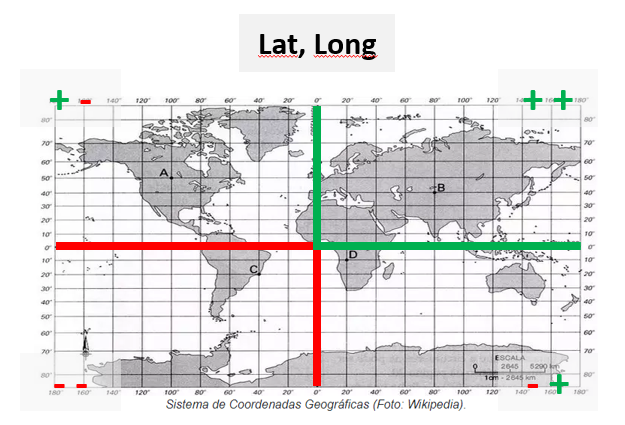

In [90]:
## check de longitude e latitude
df_adress_merge['check'] = np.where((df_adress_merge['Latitude'] > 0) | (df_adress_merge['Longitude'] > 0), 'checar', '-')

In [91]:
### Encontramos 3 valores positivos que precisam de tratativa, mas nesse caso vamos retirar da base e continuar a análise
df_adress_merge['check'].value_counts()

-         80
checar     3
Name: check, dtype: int64

In [92]:
df_adress_merge = df_adress_merge[df_adress_merge['check']=='-']

In [93]:
df_adress_merge.shape

(80, 11)

In [138]:
df_lat_long = pd.read_excel('\\bd_adress.xlsx', sheet_name='lat_long')

In [144]:
### separar base de cliente e transportador
df_adress_cliente_filter = df_lat_long[df_lat_long['grupo']=='cliente']
df_adress_transportador = df_lat_long[df_lat_long['grupo']=='transportador']

#### Parametrização

In [145]:
### configurar a base para calcular as distâncias entre todos os clientes e tranaportadores
# ler base de parâmetros
df_parameter = df_adress_cliente_filter.reset_index(drop=True)
df_adress_transportadora = df_adress_transportador.reset_index(drop=True)
df_parameter['cruzamento'] = 1
df_adress_transportadora['cruzamento'] = 1

In [148]:
## criamos uma lista que vai calcular a distância entre todos os transportadores e todos os clientes
df_full = pd.DataFrame(columns=['ID', 'Latitude',
                                'Longitude'])

key = df_parameter.index
for fun in key:
    list_transportador = df_parameter[(df_parameter.index == fun)]
    list_transportador = list_transportador['cruzamento']
    
    df_clientes_fill = df_adress_transportadora[(df_adress_transportadora['cruzamento'].isin(list_transportador))]
    
    df_clientes_fill['grupo_c'] = df_parameter['grupo'].iloc[fun]
    df_clientes_fill['ID_cliente'] = df_parameter['ID'].iloc[fun]
    df_clientes_fill['Latitude_c'] = df_parameter['Latitude'].iloc[fun]
    df_clientes_fill['Longitude_c'] = df_parameter['Longitude'].iloc[fun]

    
    df_full = df_full.append(df_clientes_fill, sort = False)

In [150]:
#Salvar base
df_full.to_excel('./df_full_v3.xlsx', index=False)

#### Calcular distância

In [151]:
#vamos calcular a distância entre todos os clientes e transportadores
from geopy import distance

In [152]:
df_full = df_full.dropna(subset=['Latitude_c', 'Longitude_c', 'Latitude', 'Longitude'])

In [153]:
df_full['Distance'] = df_full[['Latitude_c', 'Longitude_c', 'Latitude', 'Longitude']].apply(lambda x: distance.distance((x[0],x[1]), (x[2],x[3])).km, axis=1)

In [154]:
#classificar por distância ascendente
df_full = df_full.sort_values(by=['ID_cliente', 'Distance'],ascending=[True, True])

In [155]:
df_full['Distance'] = df_full['Distance'].round(decimals = 2)

In [156]:
#df_full.to_excel('./Calculo_distancia.xlsx', index=False)

In [160]:
# considerar apenas o prestador mais próximo de cada cliente
transportador_mais_proximo = df_full.drop_duplicates(['ID_cliente'], keep='first')
transportador_mais_proximo = transportador_mais_proximo.sort_values(by=['Distance'],ascending=[True])

In [170]:
# para saber a quantidade de clientes mais próximos de cada transportador
group = transportador_mais_proximo.groupby(['ID'])['ID_cliente'].count().reset_index()

In [172]:
group.head(11)

,ID,ID_cliente
0,191,8
1,192,16
2,193,28
3,194,24
4,195,21
5,196,4
6,197,18
7,198,35
8,199,9
9,200,27


In [159]:
#transportador_mais_proximo.to_excel('./transportador_mais_proximo.xlsx', index=False)